In [24]:
# Samarth Ganesh Thopaiah ~ Machine learning for signal processing 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import date
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
# from statsmodels.tsa.arima.model import ARIMA
# import statsmodels.api as smapi
from sklearn.metrics import mean_squared_error
import yfinance as yf
import os, contextlib
import glob
from tqdm.auto import tqdm

C:\Users\thopa\AppData\Local\Temp\ipykernel_26064\207407201.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [25]:
# # create a folder for data storage
# if not os.path.exists("stocks data"):
#     os.mkdir("stocks data")

# # read the NASDAQ 100 Index ticker symbols list from Wiki
# url = 'https://en.wikipedia.org/wiki/NASDAQ-100#Components'
# html = pd.read_html(url, header=0)
# series = html[4]["Ticker"]
# symbols = series.to_list()
# # download prices history
# with open(os.devnull, 'w') as devnull:
#     with contextlib.redirect_stdout(devnull):
#         for i, symbol in enumerate(symbols):
#             data = yf.download(symbol, period='max')["Close"]
#             data.to_csv('stocks data/{}.csv'.format(symbol))

KeyError: 'Ticker'

In [33]:
# Working with a single stock 
# This signal has 1170 discrete values. We use the LMS algorithm to learn the filter weights 
# Teacher forcing approach at each step 

path = "stocks_dataCLOSE/GOOGL.csv"
# csv_files = glob.glob(os.path.join(path, "norm_GOOGL.csv"))
df = pd.read_csv(path)
signal  = {}
signal['date'] = df['Date']
signal['close'] = df['Close']
# Quantizing for more accuracy ?
# Smoothing with an LPF might also work 
signal['close'] = [np.floor(i) for i in signal['close']]
signal['close'] = np.array(signal['close'])

In [27]:
class lmsPred:
    def __init__(self, u):
        # Do not alter this ~ zeros out prediction for the last day 
        self.l = 1
        self.u = 2**(-30)
        self.N = 20

        # Weight initialization
        self.wn=np.random.rand(self.N+1,1)/10
          
    def train(self, x):
        xd= np.block([np.zeros((1,self.l)), x]).T
        y=np.zeros((len(xd),1))
        xn=np.zeros((self.N+1,1))
        xn = np.matrix(xn)
        M=len(xd)
        for n in range(0,M):
            xn = np.block([[xd[n]], [xn[0:self.N]]])

            # Gradient clips at this step 
            y[n]= np.matmul(self.wn.T, xn)


            if -10 > np.sum(self.wn) > 10:
                print(self.wn)
                break  

            if(n>M-self.l-1):
                e = 0
            else:
                e= int(x[n]-y[n])
            self.wn = self.wn + 2*self.u*e*xn
        return y

    def predictToday(self):
        today = date.today()
        print("Today's date:{}".format(today))
        
        
        
 



Filter is fine-tuning on prior data.... 


100%|██████████| 4557/4557 [00:08<00:00, 558.35it/s]


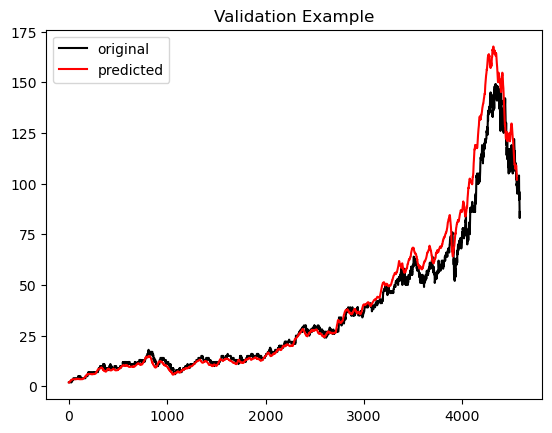

For every window size of 30,  we used 29 to learn the filter weights and 1 for validation.
We accumulate these validation scores and calcualte the MSE and MAE below:
Company: Google
Mean Squared Error:  40.42536901179655
Mean Absolute Error: 3.873190331033198


In [28]:
#  Initialize a new LMS predictor class
#  For tuning the hyperparameters 

# Parameters to consider [ u = learning rate, l = number of outputs to predict, N = filter order, x = input vector ]
# Wise to consider a smaller window ~ Ideal window size for stock market prediction

x_train = signal
x_train_max = np.max(x_train)
if x_train_max > 200:
    k = 1
else: 
    k = 0 
lr_options = [2**(-20), 2**(-30)]   

predClass = lmsPred(lr_options[k])

real_values, pred_values = [], []
print("Filter is fine-tuning on prior data.... ")

# We set the learning rate depending on the max 

for i in tqdm(range(len(x_train)-30)):
    x = x_train[i:i+30]
    result = predClass.train(x)
    pred = result[-1:]
    pred_values.append(np.squeeze(pred))
    real = x[-1]
    real_values.append(x[-1])
    
plt.plot(x_train, color = 'black')
plt.plot(pred_values, color = 'red')
plt.legend(["original", "predicted"])
plt.title("Validation Example")
plt.show()


# Printout relevant metrics
print("For every window size of 30,  we used 29 to learn the filter weights and 1 for validation.\nWe accumulate these validation scores and calcualte the MSE and MAE below:")
print("Company: Google")
print("Mean Squared Error: ",mean_squared_error(real_values, pred_values) )
print("Mean Absolute Error:", mean_absolute_error(real_values, pred_values))


### GLOBAL Validation
- Closing price prediction across all companies ~ 100 models trained
- Similar hyperparameters? 
- Data preprocessing considerations? 

In [188]:
# 2022-11-04

path = "stocks_dataCLOSE/"
csv_files = glob.glob(os.path.join(path, "*.csv"))
text_file = open("C:\\Users\\thopa\\Desktop\\Assignments\\11755_MLforSP\\Project\\AdaptiveFiltering\\log.txt","w")
# Primary validation loop 
# Extremely slow code ~ Scope for optimization (Any suggestions Anthony or Daniel?)

print("Filter is fine-tuning on prior data on all companies listed... ")
for j in tqdm(csv_files):
    df = pd.read_csv(j)
    signal = df['Close']
    signal = [np.floor(k) for k in signal]
    signal = np.array(signal)

    # New adaptive filter for every company 

    x_train = signal

    # Some steps to avoid gradient explosing or vanishing 
    x_train_max = np.max(x_train)
    if x_train_max > 200:
        k = 1
    else: 
        k = 0 
    lr_options = [2**(-20), 2**(-30)]
    predClass = lmsPred(lr_options[k])


    real_values, pred_values = [], []
    for i in range(len(x_train)-30):
        x = x_train[i:i+30]
        result = predClass.train(x)
        pred = result[-1:]
        pred_values.append(np.squeeze(pred))
        real = x[-1]
        real_values.append(x[-1])
    string = "Company {} | MSE: {} | MAE: {} \n".format(j.split("\\")[-1].split(".")[-2],mean_squared_error(real_values, pred_values), mean_absolute_error(real_values, pred_values))
    text_file.write(string)
    text_file.flush()
text_file.close()


Filter is fine-tuning on prior data on all companies listed... 


100%|██████████| 102/102 [19:10<00:00, 11.28s/it]


In [90]:
class lmsTrainPred:
    def __init__(self):
        # Do not alter this ~ zeros out prediction for the last day 
        self.u = 2**(-20)
        self.N = 60

        # Weight initialization
        self.wn=np.random.rand(self.N+1,1)/10
          
    def train(self, x):
        xd= np.block([x]).T
        y=np.zeros((len(xd),1))
        xn=np.zeros((self.N+1,1))
        xn = np.matrix(xn)
        M=len(xd)
        for n in range(0,M):
            xn = np.block([[xd[n]], [xn[0:self.N]]])

            # Gradient clips at this step 
            y[n]= np.matmul(self.wn.T, xn)
            if -10 > np.sum(self.wn) > 10:
                print(self.wn)
                break  
            else:
                e= int(x[n]-y[n])
                
            self.wn = self.wn + 2*self.u*e*xn

    def predictToday(self,x,l):
        self.l = l
        xd= np.block([np.zeros((1,self.l)), x]).T
        y=np.zeros((len(xd),1))
        xn=np.zeros((self.N+1,1))
        xn = np.matrix(xn)
        M=len(xd)
        for n in range(0,M):
            xn = np.block([[xd[n]], [xn[0:self.N]]])

            # Gradient clips at this step 
            y[n]= np.matmul(self.wn.T, xn)

            if -10 > np.sum(self.wn) > 10:
                print(self.wn)
                break  
            if(n>M-self.l-1):
                e = 0
            else:
                e= int(x[n]-y[n])
            self.wn = self.wn + 2*self.u*e*xn
        return y
        
        
        
 


        
        
 



Filter is fine-tuning on prior data.... 
Trained on data from 2004-08-19 to 4575    2022-10-20
Name: Date, dtype: object


100%|██████████| 10/10 [00:00<00:00, 260.46it/s]


2022-10-21 Prediction  [99.55586008] : Actual price 102.0: 
2022-10-24 Prediction  [102.44748479] : Actual price 104.0: 
2022-10-25 Prediction  [102.9160336] : Actual price 94.0: 
2022-10-26 Prediction  [105.93623944] : Actual price 92.0: 
2022-10-27 Prediction  [90.19320699] : Actual price 96.0: 
2022-10-28 Prediction  [88.84919116] : Actual price 94.0: 
2022-10-31 Prediction  [96.44180946] : Actual price 90.0: 
2022-11-01 Prediction  [93.61519874] : Actual price 86.0: 
2022-11-02 Prediction  [88.42917706] : Actual price 83.0: 
2022-11-03 Prediction  [82.9724029] : Actual price 86.0: 


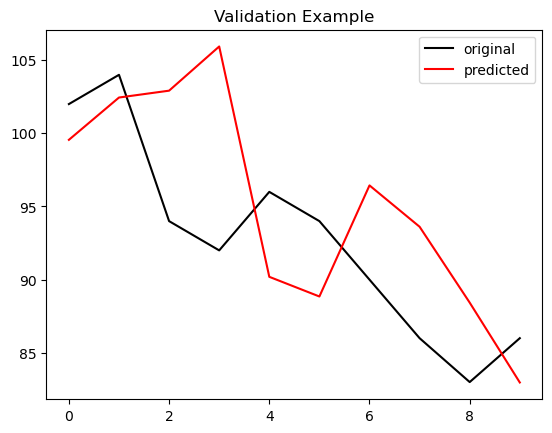

In [91]:
# Data loader 

path = "stocks_dataCLOSE/GOOGL.csv"
# csv_files = glob.glob(os.path.join(path, "norm_GOOGL.csv"))
df = pd.read_csv(path)
signal  = {}
signal['date'] = df['Date']
signal['close'] = df['Close']
# Quantizing for more accuracy ?
# Smoothing with an LPF might also work 
signal['close'] = [np.floor(i) for i in signal['close']]
signal['close'] = np.array(signal['close'])



predClass = lmsTrainPred()
real_values, pred_values = [], []
print("Filter is fine-tuning on prior data.... ")

# We set the learning rate depending on the max 

print("Trained on data from {} to {}".format(signal['date'][0], signal['date'][-12:-11]))
j = 0
train_data_v = signal['close'][:-11] # Everything before 20th 
train_data_d = signal['date'][:-11]
train_len = len(train_data_v)
for i in tqdm(range(train_len-30)):
    x = train_data_v[i:i+30]
    predClass.train(x)
# Iteratively predict and train for the last 10 days 
test_data_v = np.concatenate((train_data_v[4545:4545+30], signal['close'][-11:]), axis= 0)
test_data_d = list(signal['date'][-11:])
test_len = len(test_data_v)
prediction = []
actual = []
for i in tqdm(range(test_len-30-1)):

    # We make a prediction first, then put it into the model 
    # Pass the last 30 values 
    y_pred = predClass.predictToday(test_data_v[i:i+30],1)
    prediction.append(y_pred[-1])
    actual.append(test_data_v[30+i+1])
   
    print("{} Prediction  {} : Actual price {}: ".format(test_data_d[i],y_pred[-1], test_data_v[30+i+1])) 
    predClass.train(test_data_v[i+1:i+30+1])


plt.plot(actual, color = 'black')
plt.plot(prediction, color = 'red')
plt.legend(["original", "predicted"])
plt.title("Validation Example")
plt.show()


# # Printout relevant metrics
# print("For every window size of 30,  we used 29 to learn the filter weights and 1 for validation.\nWe accumulate these validation scores and calcualte the MSE and MAE below:")
# print("Company: Google")
# print("Mean Squared Error: ",mean_squared_error(real_values, pred_values) )
# print("Mean Absolute Error:", mean_absolute_error(real_values, pred_values))

array([], dtype=float64)

4575    2022-10-20
Name: Date, dtype: object